<a href="https://colab.research.google.com/github/BirdiD/Recommender_System/blob/master/als_matrix_factorisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mise en place d'un système de recommandation

Importer les packages necessaires

In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow as tf
# Some useful Pandas DataFrame functions.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

##MovieLens Dataset

Télchargeons la base de données de films que nous allons utiliser pour mettre en place notre système de recommandation 

In [2]:
 !curl -O http://files.grouplens.org/datasets/movielens/ml-100k.zip
 !unzip ml-100k.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4808k  100 4808k    0     0  5415k      0 --:--:-- --:--:-- --:--:-- 5409k
Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test       

Importons les données téléchargées

#####Ratings, users and items

In [3]:
#ratings
names = ['user_id', 'movie_id', 'rating', 'timestamp']
movielens_ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=names)
#users
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')
# Items, we add genre colums to the dataset
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

item_info = pd.DataFrame(movies['title'])   
item_info.columns = ['title']

movielens_ratings.head(6)

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
5,298,474,4,884182806


In [4]:
item_info

,title
0,Toy Story (1995)
1,GoldenEye (1995)
2,Four Rooms (1995)
3,Get Shorty (1995)
4,Copycat (1995)
...,...
1677,Mat' i syn (1997)
1678,B. Monkey (1998)
1679,Sliding Doors (1998)
1680,You So Crazy (1994)


In [ ]:
movies.head((5))

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,genre,all_genres
0,1,Toy Story (1995),01-Jan-1995,nan,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Comedy,Animation-Children-Comedy
1,2,GoldenEye (1995),01-Jan-1995,nan,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,Adventure,Action-Adventure-Thriller
2,3,Four Rooms (1995),01-Jan-1995,nan,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,Thriller,Thriller
3,4,Get Shorty (1995),01-Jan-1995,nan,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,Drama,Action-Comedy-Drama
4,5,Copycat (1995),01-Jan-1995,nan,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,Thriller,Crime-Drama-Thriller


#Exploring the database

La base de données contient 100000 notes attribuées par 943 utilisateurs à 1682 films. Chaque utilisateur a évalué au moins à une vingtaine de films. Chaque film a des attributs qui lui sont propres. Comme nous l'avons déjà évoqué (je vous renvoie vers mon pdf), ces attributs sont très utiles pour effectuer une recommandation. Les films et les utilisateurs sont identifiés par leurs identifiants. Nous utiliserons ces identifiants pour créer notre matrice d'évaluations. 

In [5]:
n_users = movielens_ratings.user_id.unique().shape[0]
n_items = movielens_ratings.movie_id.unique().shape[0]


print('MovieLens 100K')
print (str(n_users) + ' utilisateurs')
print (str(n_items) + ' films')
print('')


MovieLens 100K
943 utilisateurs
1682 films



Text(0.5, 1.0, "Fréquence d'évaluations des films")

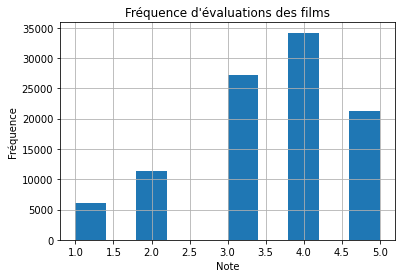

In [6]:
movielens_ratings['rating'].hist(grid=True)
plt.xlabel('Note')
plt.ylabel('Fréquence')
plt.title('Fréquence d\'évaluations des films')


In [ ]:
(movies_ratings[['title', 'rating count', 'rating mean']]
 .sort_values('rating count', ascending=False)
 .head(9))

,title,rating count,rating mean
49,Star Wars (1977),583,4.358
257,Contact (1997),509,3.804
99,Fargo (1996),508,4.156
180,Return of the Jedi (1983),507,4.008
293,Liar Liar (1997),485,3.157
285,"English Patient, The (1996)",481,3.657
287,Scream (1996),478,3.441
0,Toy Story (1995),452,3.878
299,Air Force One (1997),431,3.631


#Factorisation matricielle

Les systèmes de recommandation se décomposent en deux principales tâches: une prédiction des notes qu'un utilisateur est susceptible de donner à un item (film, livres, article etc) et la suggestion des éléments qui pourraient l'intéresser. Dans les approches de type filtrage collaboratif, ces évaluations sont regroupées dans des matrices de type utilisateur/produit où chaque ligne représente un utilisateur et chaque colonne un item (produit). On les appelle matrices d'évaluations. Elles sont non seulement de grandes tailles (des milliers voire des millions d'utilisateurs/produits) mais elles ont aussi la particularité d'être **sparse** (creuses). En effet, seul un nombre assez faible d'items se retrouvent notées ce qui fait qu'une garande partie des entrées de la matrice sont inconnues. Pour remédier à ce problème et réduire la dimensionalité des matrices d'évaluations, on les décompose en produits de matrices. On parle de factorisation matricielle.



Supposons que nous disposons d'une matrice $R$ de $\mathcal M_{m,n}(R)$ dont les entrées $r_{ui}$ sont les évaluations des films sur Netflix et où chaque ligne représente un utilisateur et chaque colonne un film. L'objectif de la factorisation matricielle est de trouver deux matrices de facteurs latents dont le produit est égale à la matrice $R$. On apprend donc un modéle latent d'utilisateurs $X$ $\in$  $\mathcal M_{m,d}(R)$ et d'items $Y$ $\in$ $\mathcal M_{d,n}(R)$ afin que le produit $\hat{r}_{ui}$ = $x_u^T$ $\cdot$ $y_i$ estime l'entrée $r_{ui}$ de la matrice $R$. Le nombre de variables latentes est égale à $d$. Ces facteurs latents sont en général les attributs des items. Dans le cas des films, il est évident que les utilisateurs préferent certains genres, acteurs ou encore réalisateurs. Ces catégories représentent les facteurs latents. Deux utilisateurs fans d'un même réalisateur ou qui apprécient un genre en particulier aiment vraisemblement des films similaires. Pour un utilisateur, un attribut peut être par exemple un nombre indiquant à quel point il aime les films de comédie et pour un film, un nombre indiquant son caractère humoristique (par exemple 1 s'il s'agit d'une comédie et 0 sinon). Par conséquent, les entrées de $X$ traduiront la force de préférence des utilisateurs pour les attributs choisis (genre du film dans notre exemple). Ces informations nous permettront de prédire les notes manquantes dans la matrice et donc recommander les films non évalués.



Pour déterminer les variables latentes $X$ et $Y$, on minimise la fonction objective suivante:
\begin{equation}
    \mathcal{L} = \sum_{(u,i)\in \Gamma }(r_{ui}-x^T_u \cdot y_i)^2
\end{equation}
Le terme $\hat{r}_{ui}$ = $x^T_u \cdot y_i$ représente la prédiction de l'évaluation de l'item $i$ par l'utilisateur $u$. $\Gamma$ est l'ensemble des ($u$,$i$) telle que $r_{ui}$ est connue. \\
Afin d'éviter le surapprentissage, on ajoute à la fonction objective précédente des termes de régularisation. L'égalité précédente se réécrit de la manière suivante:

\begin{equation}
     \mathcal{L} = \sum_{(u,i)\in \Gamma }(r_{ui}-x^T_u \cdot y_i)^2 + \lambda ({x_{u}}^2 + {y_{i}}^2)
\end{equation}

La constante de régularisation $\lambda $ est un hyperparamètre. On peut la déterminer avec une validation croisée. \\
Pour minimiser la fonction $\mathcal{L}$, nous allons utiliser la méthode des moindres carrés alternés

#Moindres carrés alternés (ALS)


La méthode des moindres carrés alternés consiste à fixer un des facteurs latents ($X$ ou $Y$) et à calculer le gradient par rapport l'autre facteur. En annulant le gradient, on trouve la règle de mise à jour d'un des facteurs. En refaisant la même opération, on détermine aisément l'autre facteur. Essayons de dériver la fonction objective. Fixons $y_i$ et annulons la dérivée:

\begin{equation}
    \frac{\partial\mathcal{L}}{\partial x_{u}} = -2\sum_{i}(r_{ui}-x^T_u \cdot y_i)y_i^T + 2\lambda x_{u}^T \\ \lambda x_{u}^T - (r_u - x_{u}^TY^T)Y = 0 \\ r_{u}Y = x_{u}^T(Y^TY+\lambda I)
\end{equation}

On en déduit que:

\begin{equation}
    \boxed{ x_{u}^T = r_{u}Y(Y^TY+\lambda I)^{-1}}
\end{equation}

En fixant $x_{i}$, le même raisonnement nous permet d'écrire:

\begin{equation}
    \boxed{ y_{i}^T = r_{i}X(X^TX+\lambda I)^{-1}}
\end{equation}
Pour chaque itération de l'algorithme, on fixe un des facteurs et on calcule l'autre. On définit ainsi une règle de mise à jour des facteurs en répétant ces itérations jusqu'à ce qu'il y ait convergence. 

**Créons notre matrice d'évaluations**

In [7]:
X = movielens_ratings[['user_id', 'movie_id']].values
y = movielens_ratings['rating'].values


print ('X')
print (X)
print ('y')
print (y)


X
[[ 196  242]
 [ 186  302]
 [  22  377]
 ...
 [ 276 1090]
 [  13  225]
 [  12  203]]
y
[3 3 1 ... 1 2 3]


In [8]:
from scipy import sparse

def Convert_to_array(X, y, shape):  
    row  = X[:,0]
    col  = X[:,1]
    data = y
    matrix_sparse = sparse.csr_matrix((data,(row,col)), shape=(shape[0]+1,shape[1]+1))  
    Ratings = matrix_sparse.todense()   
    Ratings = Ratings[1:,1:]                  
    Ratings = np.asarray(Ratings)             
    return Ratings
  

R_shape = (n_users, n_items)

Ratings = Convert_to_array(X, y, R_shape)
print (Ratings)
print (Ratings.shape)

[[5 3 4 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [5 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]]
(943, 1682)


Nous venons de créer notre matrice d'évaluations avec les utilisateurs qui représentent les lignes, les films les colonnes et les entrées qui représentent les notes attribuées à chaque film par les utilisateurs

##Définir les ensembles d'entrainement et d'évaluation

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

Ratings_train = Convert_to_array(X_train, y_train, R_shape)
Ratings_test = Convert_to_array(X_test, y_test, R_shape)

print ('Ratings_train')
print (Ratings_train)
print (Ratings_train.shape)
print('')
print ('Ratings_test')
print (Ratings_test)
print (Ratings_test.shape)

Ratings_train
[[0 0 4 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [5 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]]
(943, 1682)

Ratings_test
[[5 3 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(943, 1682)


#Notre système de recommandation

In [12]:
from sklearn.metrics import mean_squared_error

In [13]:
class ALS_Factorization():
    def __init__(self, n_iters, n_factors, reg):
        self.reg = reg
        self.n_iters = n_iters
        self.n_factors = n_factors  
        #reg est le terme de régularisation, ici lambda
        #n_factors est le nombre de facteurs latents choisi
        #n_iters est le nombre d'itérations effectué dans la descente de gradient

     #entrainer notre modèle

    def fit(self, train, test):
        self.n_user, self.n_item = train.shape
        self.user_factors = np.random.random((self.n_user, self.n_factors))
        self.item_factors = np.random.random((self.n_item, self.n_factors))
   
        self.test_mse_record  = [] # initialiser la liste des erreurs quadratiques de validaton de chauqe itération
        self.train_mse_record = []   #initialiser la liste des erreurs quadratiques d'entrainement
        for _ in range(self.n_iters):
          
            self.user_factors = self.moindres_carres(train, self.user_factors, self.item_factors)
            self.item_factors = self.moindres_carres(train.T, self.item_factors, self.user_factors) 
            predictions = self.predict()
            test_mse = self.compute_mse(test, predictions)
            train_mse = self.compute_mse(train, predictions)
            self.test_mse_record.append(test_mse)
            self.train_mse_record.append(train_mse)
        
        return self    
    
    #Algorithme d'optimisation
    def moindres_carres(self, ratings, solve_vecs, fixed_vecs):
 
        A = fixed_vecs.T.dot(fixed_vecs) + np.eye(self.n_factors) * self.reg
        b = ratings.dot(fixed_vecs)
        A_inv = np.linalg.inv(A)
        solve_vecs = b.dot(A_inv)
        return solve_vecs
    
    #prédiction des notes
    def predict(self):
        """prediction de la note de l'utilisateur"""
        pred = self.user_factors.dot(self.item_factors.T)
        return pred
        

    
    def compute_mse(y_true, y_pred):
        non_nul = np.nonzero(y_true)
        mse = mean_squared_error(y_true[non_nul], y_pred[non_nul])
        return mse
        

Fonction permettant de visualiser les résultats

In [14]:
def plot_mse(model):
    linewidth = 4
    plt.plot(model.test_mse_record, color='green',label = ' Test_MSE', linewidth = linewidth)
    plt.plot(model.train_mse_record, label = ' Training_MSE', linewidth = linewidth)
    plt.xticks(fontsize=10);
    plt.yticks(fontsize=10);
    plt.xlabel('iterations', fontsize=20)
    plt.ylabel('MSE', fontsize=20)
    plt.legend(loc = 'best')

####Visualiser nos résultats

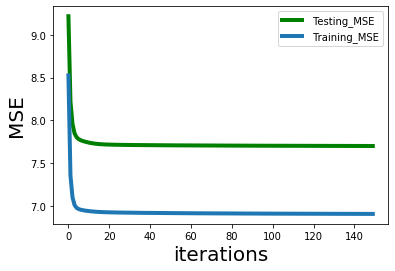

In [ ]:
als = ALS_Factorization(n_iters = 150, n_factors = 10, reg = 0.1)
als.fit(Ratings_train, Ratings_test)
plot_mse(als)

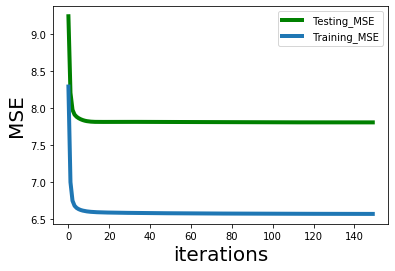

In [ ]:
model4 = ALS_Factorization(n_iters = 150, n_factors = 14, reg = 0.1)
model4.fit(Ratings_train, Ratings_test)
plot_mse(model4)

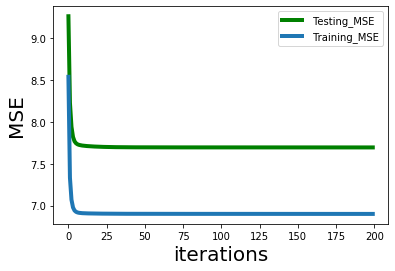

In [ ]:
mymodel = ALS_Factorization(n_iters = 200, n_factors = 10, reg = 0.1)
mymodel.fit(R_train, R_test)
plot_mse(mymodel)

A jouant sur certains paramètres clés de notre problème afin de déterminer leur influence sur le modèle, on observe que plus le nombre de facteurs latents est important, plus le modèle va être complexe et plus le temps de calcul (dérivation des facteurs latents pour les utlisateurs et les films) augmentera. 

Une petite validation croisée nous permet de trouver les paramètres qui opitmisent notre modèle sont: 10 facteurs latents et $\lambda=0.01$ avec un score MSE de $\textbf{8.011}$

###Recommandons quelques films

In [ ]:
def make_recommendation(Ratings_matrix, P_matrix, index_user, k):
  "R_matrix: matrice d'évaluation de départ"
  "P_matrix: Prediction de notre modèle"
  "k: nombre de films qu'on souhaite recommander"
  notes_de_u = pd.DataFrame(Ratings_matrix).iloc[index_user, :] #liste de toutes les évaluations de l'utilisateur u
  notes_pred_u = pd.DataFrame(P_matrix).iloc[index_user, :] #liste des notes prédites par notre modèle pour l'utilisateur u
  info_u = pd.concat([notes_de_u, notes_pred_u, item_info], axis=1)
  info_u.columns =['Notes', 'Prédiction', 'Titre']

  print('Films regardés par l\'utilisateur 50')
  print(info_u.sort_values(by='Notes', ascending=False)[:k])  
  print('')
  print('Films susceptibles de l\'interesser')
  info_u = info_u[ info_u['Notes'] == 0 ]
  print(info_u.sort_values(by='Prédiction', ascending=False)[:k])
  print()
  print()

make_recommendation(ratings, mymodel.all_rating_prediction(), index_user=50, k=6)



Films regardés par l'utilisateur 50
     Notes  Prédiction                            Titre
171  5.000       3.893  Empire Strikes Back, The (1980)
180  5.000       3.814        Return of the Jedi (1983)
172  5.000       3.714       Princess Bride, The (1987)
49   5.000       3.834                 Star Wars (1977)
143  5.000       3.884                  Die Hard (1988)
82   5.000       3.823    Much Ado About Nothing (1993)

Films susceptibles de l'interesser
      Notes  Prédiction                                        Titre
1270  0.000       4.255                                 North (1994)
1057  0.000       4.253                              War, The (1994)
1497  0.000       4.252                        Farmer & Chase (1995)
850   0.000       4.235  Two or Three Things I Know About Her (1966)
1658  0.000       4.220              Getting Away With Murder (1996)
1480  0.000       4.215                                S.F.W. (1994)




#La recommandation avec des images c'est encore mieux

Dans cette partie nous allons récupérer les posters des films et faire une recommandation avec des images. J'ai utilisé le code de $\text{ethan rosenthal}$ pour la récupération des posters grâce à l'API de  www.themoviedb.org. Voici le lien de son site https://www.ethanrosenthal.com/#. 

In [ ]:

import requests
import json
response = requests.get('https://www.imdb.com/title/tt0114709/?ref_=fn_al_tt_1')
print (response.url.split('/')[-2])

tt0114709


Voici la fonction de ethan qui récupère le poster

In [ ]:

# Get base url filepath structure. w185 corresponds to size of movie poster.
api_key = '2ad5dbf3a94ad60060c0de3b23d9f206'
headers = {'Accept': 'application/json'}
payload = {'api_key': api_key} 
response = requests.get("http://api.themoviedb.org/3/configuration",\
                        params=payload,\
                        headers=headers)
response = json.loads(response.text)
base_url = response['images']['base_url'] + 'w185'

def get_poster(imdb_url, base_url, api_key):
    # Get IMDB movie ID
    response = requests.get(imdb_url)
    movie_id = response.url.split('/')[-2]
    
    # Query themoviedb.org API for movie poster path.
    movie_url = 'http://api.themoviedb.org/3/movie/{:}/images'.format(movie_id)
    headers = {'Accept': 'application/json'}
    payload = {'api_key': api_key} 
    response = requests.get(movie_url, params=payload, headers=headers)
    try:
        file_path = json.loads(response.text)['posters'][0]['file_path']
    except:
        # IMDB movie ID is sometimes no good. Need to get correct one.
        movie_title = imdb_url.split('?')[-1].split('(')[0]
        payload['query'] = movie_title
        response = requests.get('http://api.themoviedb.org/3/search/movie',\
                                params=payload,\
                                headers=headers)
        try:
            movie_id = json.loads(response.text)['results'][0]['id']
            payload.pop('query', None)
            movie_url = 'http://api.themoviedb.org/3/movie/{:}/images'\
                        .format(movie_id)
            response = requests.get(movie_url, params=payload, headers=headers)
            file_path = json.loads(response.text)['posters'][0]['file_path']
        except:
            # Sometimes the url just doesn't work.
            # Return '' so that it does not mess up Image()
            return ''
        
    return base_url + file_path


##Testons cette fonction sur un film que j'aime bien 

In [ ]:
from IPython.display import Image
from IPython.display import display


film_bis = 'https://www.imdb.com/title/tt0112401/'
print('Vous avez regardé')
Image(url=get_poster(film_bis, base_url, api_key))

Vous avez regardé


Super ! ça fonctionne

##Essayons maintenant de recommander 

Cette fonction calcule la similarité entre les films. Pour plus de d'informations, vous pouvez aller lire les explications suivantres https://www.machinelearningplus.com/nlp/cosine-similarity/

In [ ]:
def cosine_similarity(model):
    sim = model.item_factors.dot(model.item_factors.T)
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return sim / norms / norms.T

als_sim = cosine_similarity(mymodel)

m2 = cosine_similarity(model3)
m3 = cosine_similarity(dd)
als_sim1 = cosine_similarity(als)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Recommander les films avec le score de similarité le plus élevé regardés par des utilisateurs qui ont un profil similaire (cf filtrage collaboratif). J'en ai choisi 14

In [ ]:
from IPython.display import HTML

def display_top_k_movies(similarity, mapper, movie_idx, base_url, api_key, k=14):
    movie_indices = np.argsort(similarity[movie_idx,:])[::-1]
    images = ''
    k_ctr = 0

    i = 1
    while k_ctr < 14:
        movie = mapper[movie_indices[i]]
        poster = get_poster(movie, base_url, api_key)
        if poster != '':
            images += "<img style='width: 120px; margin: 0px; \
                      float: left; border: 1px solid black;' src='%s' />"\
                      % poster
            k_ctr += 1
        i += 1
    display(HTML(images))

def compare_recs(als_similarity, mapper,\
                 movie_idx, base_url, api_key, k=14):
    # Display input
    display(HTML('<font size=4>'+'Vous avez regardé'+'</font>'))
    input_poster = get_poster(mapper[movie_idx], base_url, api_key)
    input_image = "<img style='width: 120px; margin: 0px; \
                      float: left; border: 1px solid black;' src='%s' /> <br style='clear: left'></br>" \
                  % input_poster
    display(HTML(input_image))
    # Display ALS Recs
    display(HTML('<font size=5>'+'Ces films pourraient vous intéresser'+'</font>'))
    display_top_k_movies(als_similarity, dioula_d,\
                         movie_idx, base_url, api_key)


Dictionnaire contenant les urls des films de notre base de données. C'est grâce à ces urls que nous pourrons envoyer nos requêtes de récupération de leur poster sur le site www.themoviedb.org

In [ ]:
dioula_d = {}
with open('birdib.txt', 'r',  encoding = "ISO-8859-1") as l:
  for line in l.readlines():
    splited = line.split(',')
    dioula_d[int(splited[0])] = splited[1]
    


Recommandation 

In [ ]:
 idx = 1217 # Assassins
compare_recs(m2, dioula_d, idx, base_url, api_key)

Dernière chose, regardons à quoi ressemble la matrice d'évaluations complétée

In [ ]:

print('La matrice après complétion par sgd')
print('')
print(mymodel.all_rating_prediction())

La matrice après complétion par sgd

[[3.77322932 3.5820984  3.91754048 ... 3.86593389 3.69055378 4.05930143]
 [4.16945674 3.82049267 4.72668264 ... 4.46529797 4.00764383 4.55517915]
 [3.87523008 3.66431697 4.29901611 ... 4.12057463 3.84258329 4.06387426]
 ...
 [4.35373604 3.79359312 4.75786437 ... 4.35761141 4.25547944 4.4277906 ]
 [4.13194088 3.73193911 4.34342988 ... 4.13092198 4.01696448 4.34198741]
 [3.6269688  3.5233783  3.82333253 ... 3.73160545 3.72993565 3.57223988]]
